# RNN  

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import pandas as pd
from sklearn.metrics import accuracy_score
import time

<ipython-input-1-aed6fc04839b>:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
D = 28*28
n = 256
C = 1

classes = 10

model_regular = nn.Sequential(
    nn.Flatten(),
    nn.Linear(D, n),
    nn.Tanh(),
    nn.Linear(n, n),
    nn.Tanh(),
    nn.Linear(n, n),
    nn.Tanh(),
    nn.Linear(n, classes),
)

In [3]:
h_2 = nn.Linear(n, n)

model_shared = nn.Sequential(
    nn.Flatten(),
    nn.Linear(D, n),
    nn.Tanh(), h_2,
    nn.Tanh(), h_2,
    nn.Tanh(),
    nn.Linear(n, classes),
)

# Lets build an RNN network

In [4]:
zip_file_url = "https://download.pytorch.org/tutorial/data.zip"

import requests, zipfile, io
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [5]:
namge_language_data = {}

#We will use some code to remove UNICODE tokens to make life easy for us processing wise
#e.g., convert something like "Ślusàrski" to Slusarski
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
alphabet = {}
for i in range(n_letters):
    alphabet[all_letters[i]] = i

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

#Loop through every language, open the zip file entry, and read all the lines from the text file.
for zip_path in z.namelist():
    if "data/names/" in zip_path and zip_path.endswith(".txt"):
        lang = zip_path[len("data/names/"):-len(".txt")]
        with z.open(zip_path) as myfile:
            lang_names = [unicodeToAscii(line).lower() for line in str(myfile.read(), encoding='utf-8').strip().split("\n")]
            namge_language_data[lang] = lang_names
        print(lang, ": ", len(lang_names)) #Print out the name of each language too.


Arabic :  2000
Chinese :  268
Czech :  519
Dutch :  297
English :  3668
French :  277
German :  724
Greek :  203
Irish :  232
Italian :  709
Japanese :  991
Korean :  94
Polish :  139
Portuguese :  74
Russian :  9408
Scottish :  100
Spanish :  298
Vietnamese :  73


In [6]:
namge_language_data.keys()

dict_keys(['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese'])

In [7]:
# Show the first 10 Arabic names in the dataset
print("First 10 Arabic names in the dataset:")
for i, name in enumerate(namge_language_data["Arabic"][:10], 1):
    print(f"{i}. {name}")

First 10 Arabic names in the dataset:
1. khoury
2. nahas
3. daher
4. gerges
5. nazari
6. maalouf
7. gerges
8. naifeh
9. guirguis
10. baba


In [8]:
class LanguageNameDataset(Dataset):
    '''
    self.label_names becomes ['English', 'Spanish', 'Japanese']
    self.data becomes ['Smith', 'Johnson', 'Williams', 'Garcia', 'Rodriguez', 'Lopez', 'Tanaka', 'Suzuki', 'Sato']
    self.labels becomes [0, 0, 0, 1, 1, 1, 2, 2, 2] (0 for English, 1 for Spanish, 2 for Japanese)

    Now, let's see what happens when we access a specific item, for example dataset[4]:

    The __getitem__ method is called with idx=4
    It retrieves name = self.data[4] which is 'Rodriguez'
    It retrieves label = self.labels[4] which is 1 (Spanish)
    It calls self.string2InputVec('Rodriguez') which does the following:

    Creates a tensor of zeros with length 9 (number of characters in "Rodriguez")
    For each character, it replaces the zeros with the corresponding integer from the vocabulary:

    'R' → 44
    'o' → 15
    'd' → 4
    'r' → 18
    'i' → 9
    'g' → 7
    'u' → 21
    'e' → 5
    'z' → 26


    This creates the tensor: tensor([44, 15, 4, 18, 9, 7, 21, 5, 26])


    It converts the label 1 to a tensor: tensor([1])
    It returns the tuple: (tensor([44, 15, 4, 18, 9, 7, 21, 5, 26]), tensor([1]))
    '''

    def __init__(self, lang_name_dict, vocabulary):
        self.label_names = [x for x in lang_name_dict.keys()]
        self.data = []
        self.labels = []
        self.vocabulary = vocabulary
        for y, language in enumerate(self.label_names):
            for sample in lang_name_dict[language]:
                self.data.append(sample)
                self.labels.append(y)

    def __len__(self):
        return len(self.data)

    def string2InputVec(self, input_string):
        """
        This method will convert any input string into a vector of long values, according to the vocabulary used by this object.
        input_string: the string to convert to a tensor
        """
        T = len(input_string) #How many characters long is the string?

        #Create a new tensor to store the result in
        name_vec = torch.zeros((T), dtype=torch.long)
        #iterate through the string and place the appropriate values into the tensor
        for pos, character in enumerate(input_string):
            name_vec[pos] = self.vocabulary[character]

        return name_vec

    def __getitem__(self, idx):
        name = self.data[idx]
        label = self.labels[idx]

        # Convert the correct class label into a tensor for PyTorch
        label_vec = torch.tensor([label], dtype=torch.long)

        return self.string2InputVec(name), label


In [25]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    """
    Custom collate function to pad sequences in a batch.
    Assumes `batch` is a list of (input_tensor, label) pairs,
    where input_tensor is a 1D or 2D tensor, and label is an int or tensor.
    """
    inputs, labels = zip(*batch)

    # Pad the input sequences to the same length
    padded_inputs = pad_sequence(inputs, batch_first=True, padding_value=0)

    # Convert labels to tensors if they are ints
    labels = [torch.tensor(label, dtype=torch.long) if not isinstance(label, torch.Tensor) else label for label in labels]

    # Stack labels into a tensor
    labels = torch.stack(labels)

    return padded_inputs, labels


In [26]:
dataset = LanguageNameDataset(namge_language_data, alphabet)

train_data, test_data = torch.utils.data.random_split(dataset, (len(dataset)-300, 300))

# train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
# test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

# Update DataLoader to use the custom collate function
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [27]:
# example of embedding
# ammae
'input sequence with T = 5 items but a vocabulary of only 3 items'
with torch.no_grad():
    input_sequence = torch.tensor([0, 1, 1, 0, 2], dtype=torch.long)
    embd = nn.Embedding(3, 2)
    x_seq = embd(input_sequence)
    print(input_sequence.shape, x_seq.shape)
    print(x_seq)

torch.Size([5]) torch.Size([5, 2])
tensor([[-1.1181,  0.7050],
        [-0.1864, -0.6618],
        [-0.1864, -0.6618],
        [-1.1181,  0.7050],
        [ 0.3741,  0.3528]])


In [28]:
class LastTimeStep(nn.Module):
    """
    A class for extracting the hidden activations of the last time step following
    the output of a PyTorch RNN module.
    it extracts the final hidden state from the RNN,
    which contains the model's "understanding" of the entire name sequence
    """
    def __init__(self, rnn_layers=1, bidirectional=False):
        super(LastTimeStep, self).__init__()
        self.rnn_layers = rnn_layers
        if bidirectional:
            self.num_driections = 2
        else:
            self.num_driections = 1

    def forward(self, input):
        #Result is either a tuple (out, h_t)
        #or a tuple (out, (h_t, c_t))
        rnn_output = input[0]
        last_step = input[1] #this will be h_t
        if(type(last_step) == tuple): # unless it's a tuple,
            last_step = last_step[0] # then h_t is the first item in the tuple
        batch_size = last_step.shape[1] # per docs, shape is: '(num_layers * num_directions, batch, hidden_size)'
        # reshaping so that everything is separate
        last_step = last_step.view(self.rnn_layers, self.num_driections, batch_size, -1)
        # We want the last layer's results
        last_step = last_step[self.rnn_layers-1]
        # Re order so batch comes first
        last_step = last_step.permute(1, 0, 2)
        # Finally, flatten the last two dimensions into one
        return last_step.reshape(batch_size, -1)



In [29]:
D = 64
vocab_size = len(all_letters)
hidden_nodes = 256
classes = len(dataset.label_names)

first_rnn = nn.Sequential(
  nn.Embedding(vocab_size, D), #(B, T) -> (B, T, D)
  nn.RNN(D, hidden_nodes, batch_first=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  # the tanh activation is built into the RNN object, so we don't need to do it here
  LastTimeStep(), # We need to take the RNN output and reduce it to one item, (B, D)
  nn.Linear(hidden_nodes, classes), #(B, D) -> (B, classes)
)


In [30]:
def moveTo(obj, device):
    """
    obj: the python object to move to a device, or to move its contents to a device
    device: the compute device to move objects to
    """
    if hasattr(obj, "to"):
        return obj.to(device)
    elif isinstance(obj, list):
        return [moveTo(x, device) for x in obj]
    elif isinstance(obj, tuple):
        return tuple(moveTo(list(obj), device))
    elif isinstance(obj, set):
        return set(moveTo(list(obj), device))
    elif isinstance(obj, dict):
        to_ret = dict()
        for key, value in obj.items():
            to_ret[moveTo(key, device)] = moveTo(value, device)
        return to_ret
    else:
        return obj

def run_epoch(model, optimizer, data_loader, loss_func, device, results, score_funcs, prefix="", desc=None):
    """
    model -- the PyTorch model / "Module" to run for one epoch
    optimizer -- the object that will update the weights of the network
    data_loader -- DataLoader object that returns tuples of (input, label) pairs.
    loss_func -- the loss function that takes in two arguments, the model outputs and the labels, and returns a score
    device -- the compute lodation to perform training
    score_funcs -- a dictionary of scoring functions to use to evalue the performance of the model
    prefix -- a string to pre-fix to any scores placed into the _results_ dictionary.
    desc -- a description to use for the progress bar.
    """
    running_loss = []
    y_true = []
    y_pred = []
    start = time.time()
    for inputs, labels in tqdm(data_loader, desc=desc, leave=False):
        #Move the batch to the device we are using.
        inputs = moveTo(inputs, device)
        labels = moveTo(labels, device)

        y_hat = model(inputs) #this just computed f_Θ(x(i))
        # Compute loss.
        loss = loss_func(y_hat, labels)

        if model.training:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        #Now we are just grabbing some information we would like to have
        running_loss.append(loss.item())

        if len(score_funcs) > 0 and isinstance(labels, torch.Tensor):
            #moving labels & predictions back to CPU for computing / storing predictions
            labels = labels.detach().cpu().numpy()
            y_hat = y_hat.detach().cpu().numpy()
            #add to predictions so far
            y_true.extend(labels.tolist())
            y_pred.extend(y_hat.tolist())
    #end training epoch
    end = time.time()

    y_pred = np.asarray(y_pred)
    if len(y_pred.shape) == 2 and y_pred.shape[1] > 1: #We have a classification problem, convert to labels
        y_pred = np.argmax(y_pred, axis=1)
    #Else, we assume we are working on a regression problem

    results[prefix + " loss"].append( np.mean(running_loss) )
    for name, score_func in score_funcs.items():
        try:
            results[prefix + " " + name].append( score_func(y_true, y_pred) )
        except:
            results[prefix + " " + name].append(float("NaN"))
    return end-start #time spent on epoch

def train_simple_network(model, loss_func, train_loader, test_loader=None, score_funcs=None,
                         epochs=50, device="cpu", checkpoint_file=None, lr=0.001):
    """Train simple neural networks

    Keyword arguments:
    model -- the PyTorch model / "Module" to train
    loss_func -- the loss function that takes in batch in two arguments, the model outputs and the labels, and returns a score
    train_loader -- PyTorch DataLoader object that returns tuples of (input, label) pairs.
    test_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    score_funcs -- A dictionary of scoring functions to use to evalue the performance of the model
    epochs -- the number of training epochs to perform
    device -- the compute lodation to perform training

    """
    to_track = ["epoch", "total time", "train loss"]
    if test_loader is not None:
        to_track.append("test loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if test_loader is not None:
            to_track.append("test " + eval_score )

    total_train_time = 0 #How long have we spent in the training loop?
    results = {}
    #Initialize every item with an empty list
    for item in to_track:
        results[item] = []

    #SGD is Stochastic Gradient Decent.
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch"):
        model = model.train()#Put our model in training mode

        total_train_time += run_epoch(model, optimizer, train_loader, loss_func, device, results, score_funcs, prefix="train", desc="Training")

        results["total time"].append( total_train_time )
        results["epoch"].append( epoch )

        if test_loader is not None:
            model = model.eval()
            with torch.no_grad():
                run_epoch(model, optimizer, test_loader, loss_func, device, results, score_funcs, prefix="test", desc="Testing")

    if checkpoint_file is not None:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'results' : results
            }, checkpoint_file)

    return pd.DataFrame.from_dict(results)

In [34]:
loss_func = nn.CrossEntropyLoss()
batch_one_train = train_simple_network(first_rnn,
                                    loss_func,
                                    train_loader,
                                    test_loader=test_loader,
                                    score_funcs={'Accuracy': accuracy_score},
                                    device='cpu', epochs=15)


Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

<Axes: xlabel='epoch', ylabel='test Accuracy'>

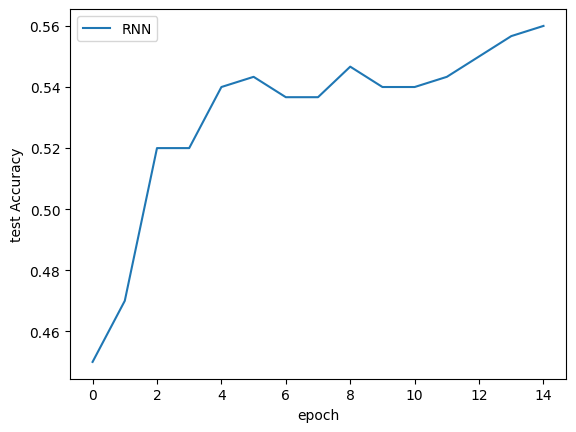

In [36]:
sns.lineplot(x='epoch', y='test Accuracy', data=batch_one_train, label='RNN')

In [38]:
pred_rnn = first_rnn.to("cpu").eval()
with torch.inference_mode():
    preds = F.softmax(pred_rnn(dataset.string2InputVec("frank").reshape(1,-1)), dim=-1)
    for class_id in range(len(dataset.label_names)):
        print(dataset.label_names[class_id], ":", preds[0,class_id].item()*100 , "%")

Arabic : 3.162110224366188 %
Chinese : 2.96990517526865 %
Czech : 6.25920444726944 %
Dutch : 3.7483390420675278 %
English : 4.402746632695198 %
French : 3.1574800610542297 %
German : 4.0082138031721115 %
Greek : 6.072365120053291 %
Irish : 2.992689050734043 %
Italian : 6.301655620336533 %
Japanese : 5.718323960900307 %
Korean : 3.415735438466072 %
Polish : 5.622952803969383 %
Portuguese : 3.20172943174839 %
Russian : 27.328887581825256 %
Scottish : 4.395610094070435 %
Spanish : 3.3824991434812546 %
Vietnamese : 3.859557956457138 %


### More simple example

In [35]:
import torch
import torch.nn as nn

# Sample data: 3 batches, each with 5 names
names_batch = [
    # Batch 1: 5 American names
    ["John", "Elizabeth", "Michael", "Jennifer", "Christopher"],

    # Batch 2: 5 Japanese names
    ["Hiroshi", "Yuki", "Takeshi", "Aiko", "Kenji"],

    # Batch 3: 5 Indian names
    ["Raj", "Priya", "Aditya", "Divya", "Vikram"]
]

# Step 1: Convert characters to indices
# First, create a vocabulary of all characters
all_chars = set()
for batch in names_batch:
    for name in batch:
        all_chars.update(name)

char_to_idx = {char: i+1 for i, char in enumerate(sorted(all_chars))}

# Add padding token
char_to_idx['<PAD>'] = 0
idx_to_char = {i: char for char, i in char_to_idx.items()}

print("Character vocabulary size:", len(char_to_idx))
print("Character mapping example:", {k: char_to_idx[k] for k in list(char_to_idx.keys())[:5]})

# Step 2: Find the longest name to determine max sequence length
max_name_length = max(len(name) for batch in names_batch for name in batch)
print("Maximum name length:", max_name_length)

# Step 3: Convert names to padded sequences of indices
# Shape will be [batch_size, seq_length, input_size]
# Where input_size=1 (one character at a time)
input_data = torch.zeros(3, 5, max_name_length, dtype=torch.long)

for batch_idx, batch in enumerate(names_batch):
    for name_idx, name in enumerate(batch):
        for char_idx, char in enumerate(name):
            input_data[batch_idx, name_idx, char_idx] = char_to_idx[char]

print("Input tensor shape:", input_data.shape)
print("\nEncoded first name in batch 1:", input_data[0, 0])
print("Decoded back:", ''.join([idx_to_char[idx.item()] for idx in input_data[0, 0] if idx.item() > 0]))

# Step 4: For RNN processing, we need to convert this to one-hot encoding or embeddings
# Let's use embeddings which is more efficient
vocab_size = len(char_to_idx)
embedding_dim = 10  # Size of character embeddings

class NameRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size):
        super(NameRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)
        # We'll use the final hidden state for classification

    def forward(self, x):
        # x shape: [batch_size, seq_length] for each name
        embedded = self.embedding(x)  # Shape: [batch_size, seq_length, embedding_dim]
        output, hidden = self.rnn(embedded)
        return output, hidden

# For processing, we'd need to reshape our data
# Let's process one batch at a time for clarity
model = NameRNN(vocab_size, embedding_dim, hidden_size=20)

# Process the first name in each batch
first_names = input_data[:, 0, :]  # Shape: [3, max_name_length]
output, hidden = model(first_names)

print("\nOutput shape for first names:", output.shape)  # Should be [3, max_name_length, 20]
print("Hidden state shape:", hidden.shape)  # Should be [1, 3, 20]

Character vocabulary size: 36
Character mapping example: {'A': 1, 'C': 2, 'D': 3, 'E': 4, 'H': 5}
Maximum name length: 11
Input tensor shape: torch.Size([3, 5, 11])

Encoded first name in batch 1: tensor([ 6, 27, 20, 26,  0,  0,  0,  0,  0,  0,  0])
Decoded back: John

Output shape for first names: torch.Size([3, 11, 20])
Hidden state shape: torch.Size([1, 3, 20])
